## Model Selection and explanations

As we have seen, before train some models, we have done some pre-modeling : interpretability methods that we use before selecting and developing our models. This has allow us to reduce the dimensionality of the problem.

With this new dataset, we have train models chosen on two purpose :
- Random Forest for is explainability : it's an in-model : by nature interpretable
- ANN for is modeling capacity. But this is a black box model thus it's a post-model (post-Hoc) : need interpretability techniques that try to enhance model interpretability after the model has been developed

We have chosen for *IncomeInvestment* to use the random forest, which have good result and allow us easier interpretability. This choice follow the fact that this set is quite unbalance so we need easy way to interpret it.

For *AccumulationInvestment*, we could have choose also the random forest which have good result, but we have choosen the NN because we have seen that playing with hyperparameter we have obtain better results (accordingly to our business orientation).

Now we need to interpret them and we will proceed as follows :
- 1. Practice global interpretability : we want to have an overall description of different models
- 2. Self interpret the predictions made by our model. We mean have a look to the result, try to find some pattern (Unsupervised ML) and have an idea about how data are distributed in the predictions
- 3. Do some local interpretability : on the results of the second step, if we have find some "clusters" while describing the results, we will apply local methods on it

We are going to use library like Lime, Shap or Eli5

[lien] https://towardsdatascience.com/understanding-machine-learning-interpretability-168fd7562a1a https://towardsdatascience.com/three-interpretability-methods-to-consider-when-developing-your-machine-learning-model-5bf368b47fac https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/

In [ ]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# Tools'libraries
from joblib import load
import shap
#from lime import lime_tabular as LT
import eli5
from sklearn.linear_model import LogisticRegression

#Our function
from modelsFct import predictionEnsemble

In [ ]:
# first we recup our data, models and target
%store -r X_test
%store -r Inc_test
%store -r Acc_test

#Load the model
%store -r modIncome
%store -r modAccumulation

columns = ["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"]

In [ ]:
%store -r dataset

#data = pd.DataFrame(X_test, colums=colums)
data = dataset[["Age"]]
data[["RatioFeature"]] = dataset[["FinancialEducation"]].values/dataset[["RiskPropensity"]].values
data[["logIncome", "logWealth"]] = dataset[["logIncome", "logWealth"]]
data_mean = np.mean(data.values, axis=0)
data_std = np.std(data.values, axis=0)

In [4]:
predictAcc = (predictionEnsemble(modAccumulation, X_test) > 0.28).astype(int)
predictInc = modIncome.predict(X_test)

### Global Interpretability

In this first part, we would like to have a precise idea of which features have the most impact on predictions, and which kind of impact : positively or negatively. 

To do this, we use Eli5 to compute weight of features, this allow us a quick global interpretability on the model. Then we use the Shap values to validate this observation and to complete it with the sign of the impact. 


#### ELI5 for our models

Eli5 look at a model’s parameters and figure out at a global level how the model works. Let's see how behave our models



In [38]:
from sklearn.ensemble import RandomForestClassifier as RF

In [39]:
# We use the first principle of interpretability: Train a simple model on the predict of a complex model
forest = RF()
forest.fit(X_test, predictAcc)
testdf = eli5.explain_weights_df(forest,feature_names=columns) # Explain weights and export them to pandas.DataFrame
testdf.head()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,feature,weight,std
0,logWealth,0.398094,0.057487
1,logIncome,0.368073,0.052249
2,Age,0.139469,0.034426
3,FinancialEducation/RiskPropensity,0.094365,0.025430


We can see that for *AccumulationInvestment*, the most impactful features are Wealth and Income. They account for approximately 75% of the prediction result. This is huge and can be interpret as a first client behaviour : the more they are at extrem values, the more the prediction is easy. We can already think that their impact are positif in the way to predict a need (true) but we will verify it with shap values.

The remaining 25% is reparted on Age and the ratio. The last one seems to have the lower impact and thus not have a particular importance. Age can still have an impact but we think that their are too many different type of people, different persona, so age can really differ.

In [16]:
#eli5.show_weights(modIncome, feature_names=columns[0:4])
testdfinc = eli5.explain_weights_df(modIncome,feature_names=columns[0:4])
testdfinc.head()

,feature,weight,std
0,logWealth,0.469183,0.066598
1,Age,0.224524,0.046951
2,logIncome,0.189954,0.034950
3,FinancialEducation/RiskPropensity,0.116338,0.019261


We can see that for *IncomeInvestment*, the most important features are Wealth and Age. Wealth account for nearly 50% of the explanation, meaning the impactof it is really strong on our prediction. It seems logical and we are waiting a positif impact, meaning a big wealth will need to a true prediction, since you are able to invest. 

We were expecting a big impact of income, with the same explanation as above, but the weight is "just" to 18%. Indeed, age seems to play a bigger role, with 23%. As we have say, age is difficult to interpret so we are expecting either positive or negative impact. 

Let's have a quick visualisation of the data, to see if these impact are observable.


We can still see that the problem is not obvious. However, really high value of wealth seems to be really impactfull and lead the prediction to true. For the rest, we need further explanation. 

So now let's use Shap values.

#### Shap Values

With the help of the shap library, we will see the impact, positive or negative, of the features on the predictions. 

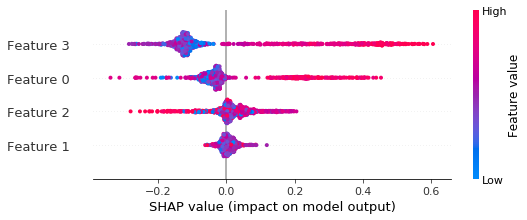

In [27]:
# Random Forest Shape values
explainerRF = shap.TreeExplainer(modIncome, feature_names=columns)
shapValuesRF = explainerRF.shap_values(X_test)
shap.summary_plot(shapValuesRF[1], X_test, class_names=columns)

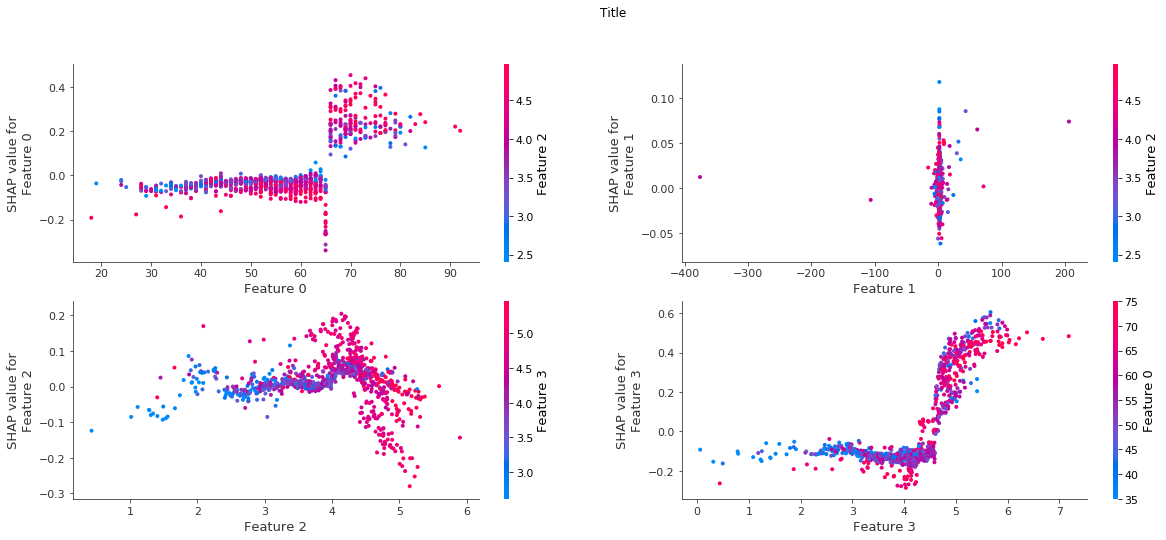

In [71]:
figure, axes = plt.subplots(2,2, figsize=(20, 8))
figure.suptitle("Title")
shap.dependence_plot(0, shapValuesRF[1], X_test*data_std+data_mean, ax=axes[0,0], show=False)
shap.dependence_plot(1, shapValuesRF[1], X_test*data_std+data_mean, ax=axes[0,1], show=False)
shap.dependence_plot(2, shapValuesRF[1], X_test*data_std+data_mean, ax=axes[1,0], show=False)
shap.dependence_plot(3, shapValuesRF[1], X_test*data_std+data_mean, ax=axes[1,1], show=False)
plt.show()

##### Shap conclusion for income investment

As we have said, *Wealth* has a important impact on the prediction. And now, we can assure that high value in this feature (feature 3) would push the result toward a True prediction. We can see this on the dependance plot where positive shap value are mostly high value of Wealth.

For the feature *Age*, we can also see that higher value give us the higher shap value. In the dependance plot we can not see patern.

For *RatioFeature* and *Income* features, thanks to the summary plot, the impact is either positive and negative and have a small impact on the prediction.

To conclude, as expected, client with high wealth are more sensible to income investment and we must have to propose them some products. Also, older clients seem more likely to have income need.  

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

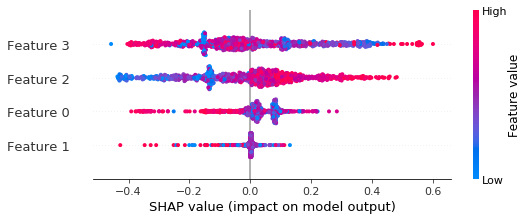

In [44]:
# Artificial Neural Network Shape values
sumShapVal = []
for index in range(3):
    explainerNN = shap.KernelExplainer(modAccumulation[index], X_test[:100,:], feature_names=columns)
    shapValuesNN = explainerNN.shap_values(X_test)
    sumShapVal.append(shapValuesNN[0])
shap.summary_plot(sum(sumShapVal)/3, X_test)

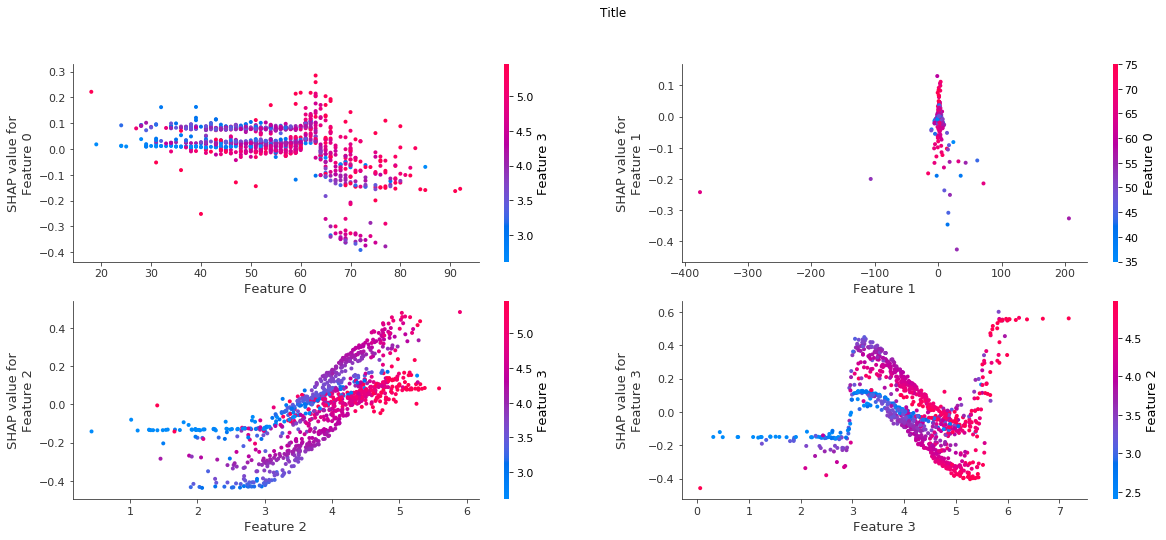

In [72]:
figure, axes = plt.subplots(2,2, figsize=(20, 8))
figure.suptitle("Title")
shap.dependence_plot(0, sum(sumShapVal)/3, X_test*data_std+data_mean, ax=axes[0,0], show=False)
shap.dependence_plot(1, sum(sumShapVal)/3, X_test*data_std+data_mean, ax=axes[0,1], show=False)
shap.dependence_plot(2, sum(sumShapVal)/3, X_test*data_std+data_mean, ax=axes[1,0], show=False)
shap.dependence_plot(3, sum(sumShapVal)/3, X_test*data_std+data_mean, ax=axes[1,1], show=False)
plt.show()

##### Shap conclusion for accumulation investment

As expected, *Income* behave as we have seen before for the wealth. Meaning high income leeds you to an accumulation need. This is not really reflected on the dependance plot.

Wealth, the most important feature in this case, seems to have a strange shap values repartition. On the dependance plot, high wealth value differ between small or high shap values. Very small wealth are between [-0.2,0] meaning as expected that it will push the client to not have accumulation need.

For the feature *Age*, we can say that older people are also non-need client. 

For *RatioFeature* the impact is negligeable.

To conclude, there is no clear pattern here. We see that *Wealth* and *Age* will play an important role on the prediction and older clients are most likely people without accumulation need. 

### Local Interpretability

here we are (again)

In [73]:
# Let 
df =  np.insert(data ,4, predictAcc, axis=1)
df =  np.insert(df ,5, predictInc, axis=1)
df = pd.DataFrame(data, columns=columns)
df.describe()

NameError: name 'predRFAcc' is not defined

In [107]:
mean = [data_mean[0], data_mean[3]/data_mean[4], data_mean[5], data_mean[6],0, 0]
std = [data_std[0], data_std[3]/data_std[4], data_std[5], data_std[6],1, 1]

df_true = pd.DataFrame(df*std+mean, columns=columns)
df_true.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth,Acc,Inc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.786000,1.973353,3.865530,4.132356,0.435000,0.254000
std,11.741638,27.347839,0.798926,0.907781,0.496005,0.435515
min,18.000000,-703.465770,0.430330,0.057911,0.000000,0.000000
25%,47.000000,1.141692,3.427784,3.572470,0.000000,0.000000
50%,55.000000,1.932128,3.958148,4.178830,0.000000,0.000000
75%,63.000000,2.570810,4.428945,4.757747,1.000000,1.000000
max,92.000000,384.447699,5.900783,7.183172,1.000000,1.000000


For accumulation, it is hard to see a pattern, only logincome seems to have a particular repartition.
However, as we have said, in income investment, the wealth play a big role and thus high wealth give prediction to true. We expect to have such a replication in clustering. Even age and logincome seems to have a particular shape. 

In [109]:
# let's recup exactly the peole who have need or not in both target
UL_test = df_UL.values
UL = df.values

Acc_true  = UL_test[(UL[:,4]==1)]
Acc_false = UL_test[(UL[:,4]==0)]

Inc_true  = UL_test[(UL[:,5]==1)]
Inc_false = UL_test[(UL[:,5]==0)]


We are going to train a Kmedoids model because it is less sensitive to noise and outlier in data than a Kmean.

We will do it on separating in both target into the subset of true and false prediction. Thus we have 4 dataset to model.

Text(0, 0.5, 'Inertia (within-cluster sum of squares)')

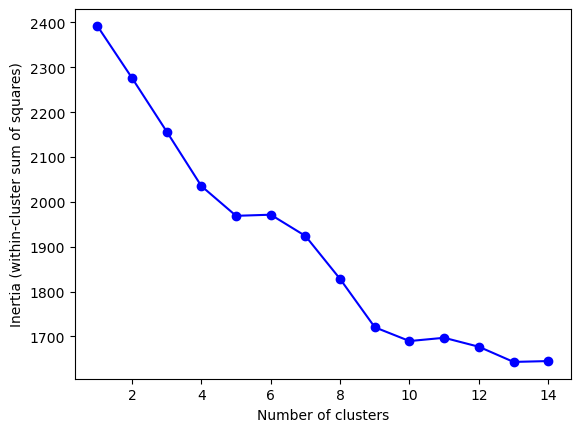

In [117]:
from sklearn_extra.cluster import KMedoids as KM

# start with accu true
Km = range(1, 15)
inertia = [KM(i).fit(Acc_true).inertia_ for i in Km]

fig = plt.figure()
plt.plot(Km, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')

In [111]:
medoids = KM(10).fit(UL_test)
labels = medoids.predict(Acc_true)
#plt.scatter(Acc_true[:, 0], Acc_true[:, 1], c=labels, s=40)

print(medoids.cluster_centers_*std[0:4] + mean[0:4])
a, count = np.unique(labels, return_counts=True)
print("classes",a,"distributed as :", count)

[[71.          2.88480128  4.65104662  5.29567803]
 [51.          0.31878009  4.13329511  4.08940645]
 [49.          2.38619807  3.94822049  3.97979394]
 [61.          1.87768428  4.59058713  4.56561126]
 [49.          1.84451166  4.38241172  4.84117527]
 [66.          1.67155543  3.9429569   4.69701509]
 [59.         -4.41255449  3.64487724  4.12280973]
 [47.          1.83829343  3.32491299  3.19880072]
 [57.         12.02348934  4.20659151  4.67297979]
 [65.          1.84176875  3.24180805  3.7583041 ]]
classes [0 1 2 3 4 5 6 7 8 9] distributed as : [60 70 91 55 36 24 24 44 19 12]


In [112]:
# if we want to see the repartition within a cluster
first = Acc_true[labels[:]==0]
tty = pd.DataFrame(first*std[0:4] + mean[0:4], columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
tty.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth
count,60.000000,60.000000,60.000000,60.000000
mean,68.933333,3.131831,4.745010,5.392748
std,8.550680,1.404973,0.494298,0.622705
min,52.000000,0.670778,3.382266,4.102450
25%,63.000000,2.132974,4.612903,4.864535
50%,69.000000,2.708741,4.805110,5.407265
75%,75.250000,3.743147,5.103396,5.844091
max,92.000000,6.449044,5.591129,7.183172


Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

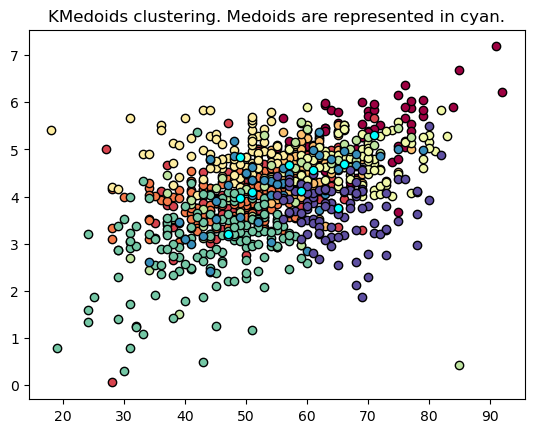

In [116]:
labels = medoids.labels_
cluster = medoids.cluster_centers_*std[0:4] + mean[0:4],
i, j = 0,3
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = UL_test[class_member_mask]
    plt.plot(
        xy[:, i]*std[i] + mean[i],
        xy[:, j]*std[j] + mean[j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    medoids.cluster_centers_[:, i]*std[i] + mean[i],
    medoids.cluster_centers_[:, j]*std[j] + mean[j],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

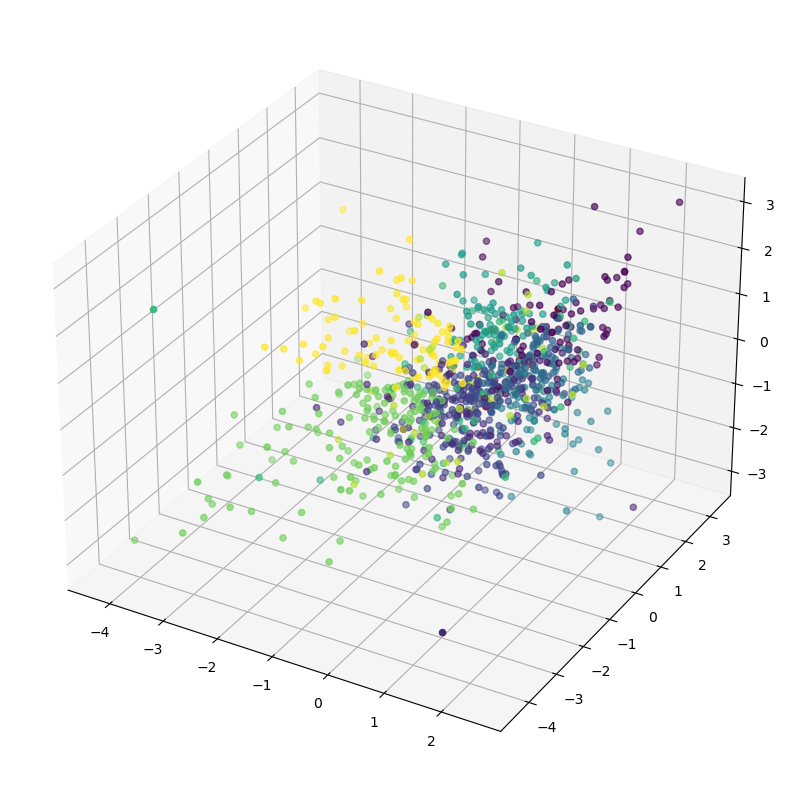

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["logIncome"], df["logWealth"],df["Age"], c=labels ) 
ax.scatter(medoids.cluster_centers_[:,2], medoids.cluster_centers_[:,3],medoids.cluster_centers_[:,0], c="r" ) 

plt.show()


# Local interpretability 

Do shap eli5 or other on : 
- cluster center
- exagerated data made by hand
- outlier or simple sample 

conclude